<a href="https://colab.research.google.com/github/sivasurasani/Material-Science-Research/blob/main/10072024_Intersection_point.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aim : To read the aluminium alloys data, find the uniform elongation point, calculate the values of k and n.

Intersection Point: True Strain = None, True Stress = None


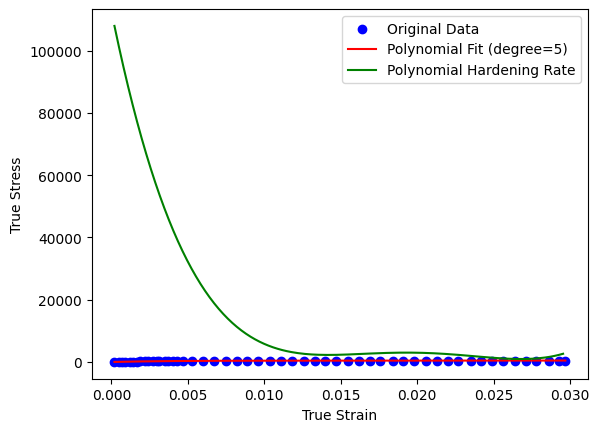

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import statsmodels.api as sm

# Define the work hardening function
def work_hardening(true_stress, true_strain):
    if len(true_stress) != len(true_strain):
        raise ValueError("true_stress and true_strain must have the same length")

    if len(true_stress) < 2:
        return np.array([])

    work_hardening_rate = np.diff(true_stress) / np.diff(true_strain)
    return work_hardening_rate

# Read the Excel file
data = pd.read_excel('Eng Values.xlsx')
if 't.stress' not in data.columns and 't.strain' not in data.columns:
    data['t.stress'] = data['eng.stress'] * (1 + data['eng.strain'])
    data['t.strain'] = np.log(1 + data['eng.strain'])

# Choose the degree of the polynomial
degree = 5

# Perform the polynomial fit for true stress
coefficients_stress = np.polyfit(data['t.strain'], data['t.stress'], degree)
polynomial_stress = np.poly1d(coefficients_stress)

# Generate evenly spaced values over the range of the original true strain values
new_true_strain = np.linspace(data['t.strain'].min(), data['t.strain'].max(), 200)
fitted_true_stress = polynomial_stress(new_true_strain)

# Calculate Work Hardening Rate
work_hardening_rate = work_hardening(fitted_true_stress, new_true_strain)
work_hardening_rate_padded = np.append(work_hardening_rate, np.nan)

# Fit a polynomial to the work hardening rate
coefficients_hardening = np.polyfit(new_true_strain[:-1], work_hardening_rate, degree)
polynomial_hardening = np.poly1d(coefficients_hardening)

# Find the first point where the hardening rate is less than the true stress
intersection_strain = None
intersection_stress = None
for strain in new_true_strain:
    if polynomial_hardening(strain) <= polynomial_stress(strain):
        intersection_strain = strain
        intersection_stress = polynomial_stress(strain)
        break

# Output the intersection point
print(f'Intersection Point: True Strain = {intersection_strain}, True Stress = {intersection_stress}')

# Plot the original data, the polynomial fit, and the hardening curve
plt.scatter(data['t.strain'], data['t.stress'], label='Original Data', color='blue')
plt.plot(new_true_strain, fitted_true_stress, label=f'Polynomial Fit (degree={degree})', color='red')
plt.plot(new_true_strain[:-1], polynomial_hardening(new_true_strain[:-1]), label='Polynomial Hardening Rate', color='green')

# Highlight the intersection point
if intersection_strain and intersection_stress:
    plt.scatter(intersection_strain, intersection_stress, color='black', zorder=5)
    plt.text(intersection_strain, intersection_stress, f'Intersection\n({intersection_strain:.3f}, {intersection_stress:.3f})',
             horizontalalignment='right')

plt.xlabel('True Strain')
plt.ylabel('True Stress')
plt.legend()
plt.show()


fitted_data = pd.DataFrame({
    't.strain': new_true_strain,
    't.stress': fitted_true_stress
})

fitted_data['hard.Rate'] = np.append(work_hardening_rate, np.nan)
fitted_data.to_excel('fitted_hard_rate_cal.xlsx', index=False)

n = 0.47689137360529144
k = 2917.974736527014
[0.0002     0.00034824 0.00049648 0.00064472 0.00079296 0.00094121
 0.00108945 0.00123769 0.00138593 0.00153417 0.00168241 0.00183065
 0.00197889 0.00212714 0.00227538 0.00242362 0.00257186 0.0027201
 0.00286834 0.00301658 0.00316482 0.00331307 0.00346131 0.00360955
 0.00375779 0.00390603 0.00405427 0.00420251 0.00435075 0.00449899
 0.00464724 0.00479548 0.00494372 0.00509196 0.0052402  0.00538844
 0.00553668 0.00568492 0.00583317 0.00598141 0.00612965 0.00627789
 0.00642613 0.00657437 0.00672261 0.00687085 0.0070191  0.00716734
 0.00731558 0.00746382 0.00761206 0.0077603  0.00790854 0.00805678
 0.00820503 0.00835327 0.00850151 0.00864975 0.00879799 0.00894623
 0.00909447 0.00924271 0.00939095 0.0095392  0.00968744 0.00983568
 0.00998392 0.01013216 0.0102804  0.01042864 0.01057688 0.01072513
 0.01087337 0.01102161 0.01116985 0.01131809 0.01146633 0.01161457
 0.01176281 0.01191106 0.0120593  0.01220754 0.01235578 0.01250402
 0.01265226 0.012

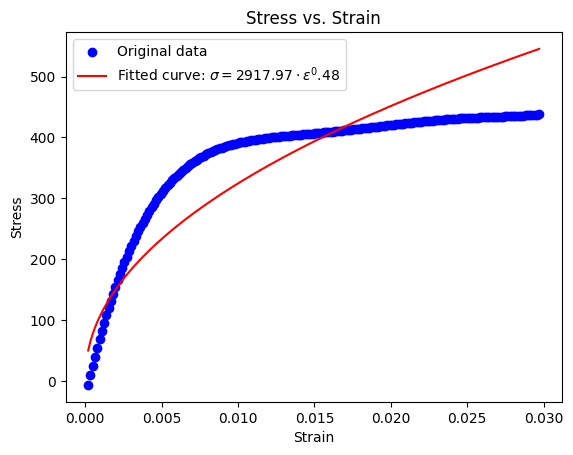

In [ ]:
def calculate_hollomon_constants(strain, stress):
    # Filter out non-positive values
    valid_indices = (strain > 0) & (stress > 0)
    strain = strain[valid_indices]
    stress = stress[valid_indices]

    # Transforming the data to natural logarithms
    log_strain = np.log(strain)
    log_stress = np.log(stress)

    # Performing linear regression
    X = sm.add_constant(log_strain)  # Adds a constant term to the predictor
    model = sm.OLS(log_stress, X).fit()
    intercept, slope = model.params

    # Calculating k
    k = np.exp(intercept)

    return slope, k

def plot_stress_strain(strain, stress, n, k):
    # Generate fitted stress values using the Hollomon equation
    fitted_stress = k * (strain**n)
    # Plot original data
    plt.scatter(strain, stress, color='blue', label='Original data')
    # Plot fitted curve
    plt.plot(strain, fitted_stress, color='red', label=f'Fitted curve: $\sigma = {k:.2f} \cdot \epsilon^{n:.2f}$')
    intersect_strain = []
    intersect_stress = []
    intersect_strain.append(intersection_strain)
    intersect_stress.append(intersection_stress)
    print(strain)
    intersect_stress.append([] * (len(strain)-1))
    intersect_strain.append([] * (len(strain)-1))
    plotted_data = pd.DataFrame({
      't.strain': strain,
      'original.stress': stress,
      'calculated_stress' : fitted_stress,
      'hard.Rate' : fitted_data['hard.Rate'],
      "Intersection_strain" : intersection_strain,
      "Intersection_stress" : intersection_stress
     })
    plotted_data.to_excel('Data.xlsx', index=False)

    plt.xlabel('Strain')
    plt.ylabel('Stress')
    plt.legend()
    plt.title('Stress vs. Strain')
    plt.show()

stress = fitted_true_stress
strain= new_true_strain

try:
    n, k = calculate_hollomon_constants(strain, stress)
    print(f'n = {n}')
    print(f'k = {k}')
    plot_stress_strain(strain, stress, n, k)
except ValueError as e:
    print(e)

Above code uses the fitted data to predict the stress strain curve using values of k and n

n = 0.5670350815435595
k = 4369.751556683737


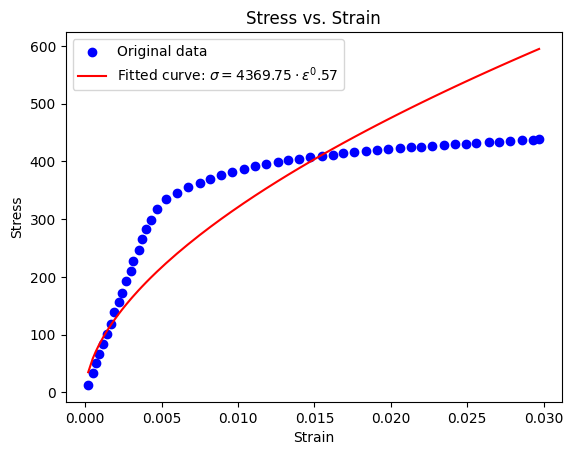

In [ ]:
def calculate_hollomon_constants(strain, stress):
    # Filter out non-positive values
    valid_indices = (strain > 0) & (stress > 0)
    strain = strain[valid_indices]
    stress = stress[valid_indices]

    # Transforming the data to natural logarithms
    log_strain = np.log(strain)
    log_stress = np.log(stress)

    # Performing linear regression
    X = sm.add_constant(log_strain)  # Adds a constant term to the predictor
    model = sm.OLS(log_stress, X).fit()
    intercept, slope = model.params

    # Calculating k
    k = np.exp(intercept)

    return slope, k

def plot_stress_strain(strain, stress, n, k):
    # Generate fitted stress values using the Hollomon equation
    fitted_stress = k * (strain**n)
    # Plot original data
    plt.scatter(strain, stress, color='blue', label='Original data')
    # Plot fitted curve
    plt.plot(strain, fitted_stress, color='red', label=f'Fitted curve: $\sigma = {k:.2f} \cdot \epsilon^{n:.2f}$')
    plt.xlabel('Strain')
    plt.ylabel('Stress')
    plt.legend()
    plt.title('Stress vs. Strain')
    plt.show()

data = pd.read_excel('Eng Values.xlsx')
if 't.stress' not in data.columns and 't.strain' not in data.columns:
    data['t.stress'] = data['eng.stress'] * (1 + data['eng.strain'])
    data['t.strain'] = np.log(1 + data['eng.strain'])
stress = data['t.stress']
strain = data['t.strain']
# stress = fitted_true_stress
# strain= new_true_strain

try:
    n, k = calculate_hollomon_constants(strain, stress)
    print(f'n = {n}')
    print(f'k = {k}')
    plot_stress_strain(strain, stress, n, k)
except ValueError as e:
    print(e)

Above code uses the original data and predicts the stress strain curve using the value of k and N